# Project 2: Solving quantum systems numerically

## Part 2: Monte Carlo Methods

In [4]:
#Here we attempt to integrate a quantum-mechanical wavefunction using 
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, 'Probability Density')

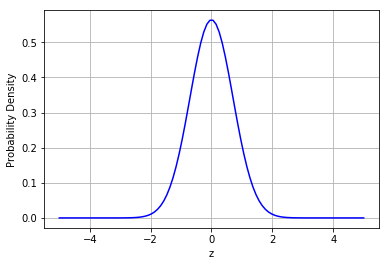

In [5]:
#defining our wavefunction and plotting it looks like a good start
#actually what is usefull here the wavefunction squared:
def psi_squared(z):
    return (1 / np.sqrt(np.pi)) * np.exp(-(z*z))

#create some z-space
zspace = np.linspace(-5,5,100)

#plot

plt.plot(zspace,psi_squared(zspace),color = "blue",label = "Single Particle Wavefunction")
plt.grid()
plt.xlabel("z")
plt.ylabel("Probability Density")
#plt.legend(loc = "lower right")

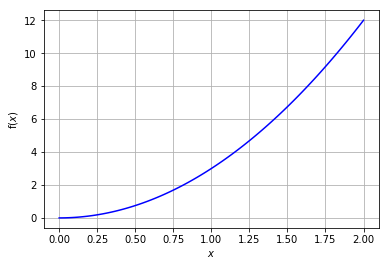

In [6]:
#I will try ti implement the extended trapezium rule
#this is not as straight forward as it first seemed
#I will define a simple function (of which I know the integral) to integrate over

def curve(x):
    return 3 * x * x

#get some plotting space
xspace = np.linspace(0,2,100)

plt.plot(xspace,curve(xspace), color = "blue")
plt.xlabel("$x$")
plt.ylabel("f$(x)$")
plt.grid()
plt.show()

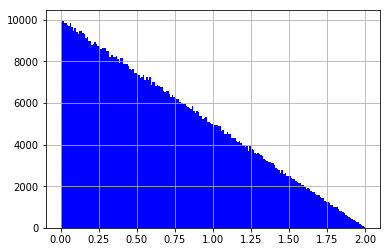

In [7]:
#we also need a valid deviate to perform imortance sampling
#consider the pdf A*x + B where A = -0.5 and B =1
#if you apply the transformation method we get
u = np.random.uniform(0,1,1000000)
#plt.hist(u)
#as an impotance sampling fuction I will define the transformation function

def linear(u):
    '''
    Linear Importance samlpling function
    Return the function to tranform a uniform deviate into a linear one and also the form of the pdf as (transformation,PDF)
    '''
    return 2 - 2*np.sqrt(np.abs(1 - u)) , (-0.5*u + 1)   

x = linear(u)[0]

plt.hist(x, bins = 200, color = "blue") #just to check
plt.grid()

In [8]:
#below is my complete Monte Carlo integration function:
#An additional feature that forces the accuracy to fall below epsilon n consequitive times is added to solve the problem
#discussed above

def mc_integrate(f,a,b,epsilon,n,importance_sampling_function = None,  rejection = False):
    
    '''
    This function integrates a function f in the interval [a,b] with a relative accuracy of epsilon.
    The function is sampled unti lthe relative accuracy falls below epsilon n consequitive times
    The user can supply an importnace sampling function  (importance_sampling_function).
    The parameter Rejection controls whether the rejection or tranformation method is used to compute
    the sampling deviate
    If the tranformation method is chosen the user must provide both the pdf and the tranformation function
    as a single function that returns (transformation(x),pdf(x)) for a given x
    This function returns an array of the form [Integral,error,(N+1),epsilon]
    '''
    
    Qlist = [] #this is a list that stores all the values of Q --> useful in getting the standard deviation in the end
    Q = f  
    if importance_sampling_function == None: #it's better to separate the two cases completely
        
        print ("No Importance Sampling")
        N = 1 #number to times the function is sampled
        accuracy = np.inf
        a_count = 0 #count how many times the accuracy fell below epsilon
        x = np.random.uniform(a,b)  
        Average = Q(x)
        Qtotal = Q(x)
        acount = 0
        while acount < n:
            N += 1
            x = np.random.uniform(a,b) 
            Qi = Q(x)
            Qtotal += Qi
            Qlist.append(Qi) #store all samples in a single list
            AverageNew = Qtotal / N
            accuracy = np.abs((AverageNew - Average) / Average)
            Average = AverageNew

            if accuracy < epsilon:
                acount += 1
            else:
                acount = 0     
            #integral there the function average
            #hecne the final integral is Ingeral * (b -a)
        Integral = Average * np.abs(a-b)
        std = np.std(Qlist)
    
    
    elif rejection == True:
        print (Q)
        print ("Importance Sampling Using Rejection Method")
        P = importance_sampling_function
        C = importance_sampling_function(0)
        print ("Comparison Line C = " +str(C))
        #start from a random point in x
        #x = start
        N = 0
        Average = 1 #this is only used in the first evaluation of the accuracy so we can set it to any value we want
                #it take a proper value later
        Qtotal = 0
        accuracy = np.inf
        acount = 0
      
        while acount < n:

            xi = np.random.uniform(a,b)
            Pi = np.random.uniform(0,C)

                  
            if P(xi) > Pi:
                N += 1
                Qi_u = Q(xi) / P(xi)  
                Qtotal += Qi_u
                Qlist.append(Qi_u) #store all samples in a single list  
                AverageNew = Qtotal / N
                accuracy = np.abs((AverageNew - Average) / Average)
                Average = AverageNew
                
                if accuracy < epsilon:
                    acount += 1
                else:
                    acount = 0
        Integral = Average
        std = np.std(Qlist)
        
    else:
        print ("Importance Sampling using the transformation method")
        N = 0 #number to times the function is sampled
        accuracy = np.inf
        a_count = 0 #count how many times the accuracy fell below epsilon
        u = np.random.uniform(0,1)
        x = importance_sampling_function(u)[0] #[0] reutrns the tranformation function used to compute a deviate that follows the sampling pdf
        Average = Q(x)
        Qtotal = Q(x)
        acount = 0
        while acount < n:
            N += 1
            u = np.random.uniform(0,1) #draw sample from uniform deviate
            x = importance_sampling_function(u)[0] #transform this to the required PDF
            Qi_u = Q(x) / importance_sampling_function(x)[1] # [1] returns the actual value of the pdf at x
            Qtotal += Qi_u  
            Qlist.append(Qi_u) #store all samples in a single list
            
            AverageNew = Qtotal / N
            accuracy = np.abs((AverageNew - Average) / Average)
            Average = AverageNew
            
            if accuracy < epsilon:
                acount += 1
            else:
                acount = 0
            
            #integral there the function average
            #hecne the final integral is Ingeral * (b -a)
        Integral = Average
        std = np.std(Qlist)
        N = len(Qlist)
    error = std / np.sqrt(N)
           
    print ("The integral is" , str(Integral), " +- ", str(error))
    print ("Number of Samples" , str(N))
    
    return [Integral,error,(N+1),epsilon]

Below are some tests of the above function

In [9]:
mc_integrate(psi_squared,0,2,1.0E-5,1000)

No Importance Sampling
The integral is 0.4987747816427118  +-  0.0005457958064323103
Number of Samples 127191


[0.4987747816427118, 0.0005457958064323103, 127192, 1e-05]

In [11]:
mc_integrate(psi_squared,0,2,1.0E-5,1000,importance_sampling_function = linear)

Importance Sampling using the transformation method
The integral is 0.49853213679754904  +-  0.0005146056805368752
Number of Samples 59023


[0.49853213679754904, 0.0005146056805368752, 59024, 1e-05]

In [12]:
mc_integrate(psi_squared,0,2,1.0E-5,1000,importance_sampling_function = linear)

Importance Sampling using the transformation method
The integral is 0.4968550259457833  +-  0.0005231680679828672
Number of Samples 59389


[0.4968550259457833, 0.0005231680679828672, 59390, 1e-05]

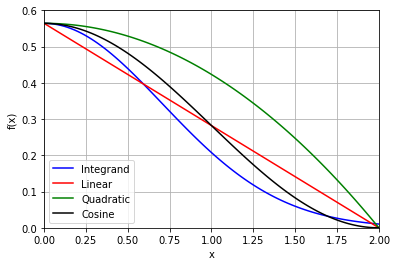

In [13]:
#attempt different importance sampling functions

def quadratic(x):
    return (3/16) * (4 - (x*x))

def cosine(x):
    return (np.cos(x*np.pi/2)+1) / 2

def line(x):
    return (-0.5*x) + 1
x = np.linspace(0,2,100)

#plt.plot(x,gaussian(x),"--",color = "black")
#rescale for plotting
a = psi_squared(0)

#plt.plot(x,psi_squared(x))
plt.plot(x,psi_squared(x),color = "blue",label = "Integrand")
plt.plot(x,line(x)*a / line(0), label = "Linear", color =  "red")
plt.plot(x,quadratic(x) * a / quadratic(0), label = "Quadratic", color = "green")
plt.plot(x, cosine(x) * a / cosine(0), label = "Cosine",color = "black")
plt.grid()
plt.axis([0,2,0,0.6])
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend(loc = "lower left")
plt.savefig("sampling_functions.pdf")

In [14]:
mc_integrate(psi_squared,0,2,1.0E-5,1000, importance_sampling_function = quadratic,rejection = True)

<function psi_squared at 0x7f7ffbf96048>
Importance Sampling Using Rejection Method
Comparison Line C = 0.75
The integral is 0.4980746313509625  +-  0.0007560088512533832
Number of Samples 70683


[0.4980746313509625, 0.0007560088512533832, 70684, 1e-05]

In [16]:
#make a function to automatically evaluate functions and store them appropriately:
data = [] #make a list to hold the data
for exponent in range(2,4,1): #iterate for different values of relative accuracy evaluating the Simpson rule every time
    print(exponent)
    epsilon = 1 * 10 ** (-exponent)
    data.append(mc_integrate(psi_squared,0,2,epsilon,1000,importance_sampling_function = cosine, rejection = True))
data

2
<function psi_squared at 0x7f7ffbf96048>
Importance Sampling Using Rejection Method
Comparison Line C = 1.0
The integral is 0.493873791149126  +-  0.002109623541603666
Number of Samples 1155
3
<function psi_squared at 0x7f7ffbf96048>
Importance Sampling Using Rejection Method
Comparison Line C = 1.0
The integral is 0.496524139794106  +-  0.001768564089494284
Number of Samples 1206


[[0.493873791149126, 0.002109623541603666, 1156, 0.01],
 [0.496524139794106, 0.001768564089494284, 1207, 0.001]]